In [ ]:
%pip install opencv-python unidecode matplotlib sympy openpyxl -q

Note: you may need to restart the kernel to use updated packages.


Este código apresenta um sistema de identificação do nível do óleo de um transformador de potência, por meio de imagens termográficas. O objetivo é avaliar a precisão dos dados obtivos computacionalmente em comparação com os dados experimentais.

_**Nota**: para realizar essa identificações é crucial que a imagem termográfica não apresente ponteiros de indicação de temperatura._

## Dependências

In [34]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from sympy import symbols
from unidecode import unidecode
import matplotlib.pyplot as plt
from IPython.display import clear_output

images_path = Path("images")

## Resultados Experimentais

Os resultados experimentais foram filtrados para apresentar apenas a região `frontal` do transformador.

In [3]:
tables = pd.read_excel("experimental_results.xlsx", header=1)
tables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Nivel do óleo             45 non-null     int64 
 1   Temperatura do óleo (Cº)  45 non-null     int64 
 2   Face                      45 non-null     object
 3   Código da foto            45 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ KB


In [4]:
tables.head()

,Nivel do óleo,Temperatura do óleo (Cº),Face,Código da foto
0,1,50,Frontal,8645
1,1,50,Radiador,8649
2,1,50,Oposta do radiador,8651
3,1,60,Frontal,8653
4,1,60,Radiador,8655


In [5]:
df = tables.copy()
df.columns = tables.columns.str.lower().str.replace(" ", "_").map(unidecode)
df = df[1:].query("face == 'Frontal'").reset_index(drop=True)
df["codigo_da_foto"] = df["codigo_da_foto"].astype(str)
df.head()

,nivel_do_oleo,temperatura_do_oleo_(co),face,codigo_da_foto
0,1,60,Frontal,8653
1,1,70,Frontal,8659
2,1,80,Frontal,8665
3,1,90,Frontal,8673
4,2,50,Frontal,8679


In [6]:
raw_images = images_path / "raw_data_no_pointers"

# caminho das imagens filtradas
df["img_path"] = raw_images / ("FLIR" + df["codigo_da_foto"] + ".jpg")

df

,nivel_do_oleo,temperatura_do_oleo_(co),face,codigo_da_foto,img_path
0,1,60,Frontal,8653,images\raw_data_no_pointers\FLIR8653.jpg
1,1,70,Frontal,8659,images\raw_data_no_pointers\FLIR8659.jpg
2,1,80,Frontal,8665,images\raw_data_no_pointers\FLIR8665.jpg
3,1,90,Frontal,8673,images\raw_data_no_pointers\FLIR8673.jpg
4,2,50,Frontal,8679,images\raw_data_no_pointers\FLIR8679.jpg
5,2,60,Frontal,8685,images\raw_data_no_pointers\FLIR8685.jpg
6,2,70,Frontal,8705,images\raw_data_no_pointers\FLIR8705.jpg
7,2,80,Frontal,8691,images\raw_data_no_pointers\FLIR8691.jpg
8,2,90,Frontal,8697,images\raw_data_no_pointers\FLIR8697.jpg
9,3,50,Frontal,8713,images\raw_data_no_pointers\FLIR8713.jpg


## Testes de Identificação do Nível

Realização de testes para identificação do nível óleo

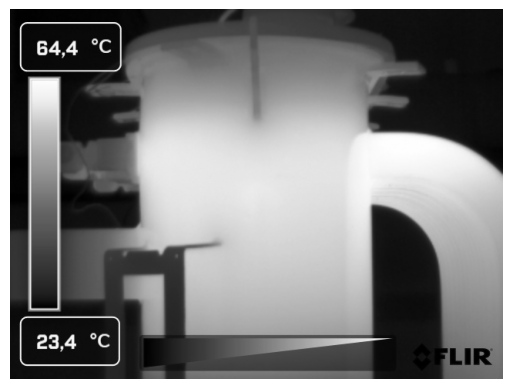

In [7]:
# seleção de uma imagem qualquer, e a sua conversão para a escala de cinza
img = cv2.imread(df["img_path"][10])
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray, cmap="gray")
plt.axis("off")
plt.show()

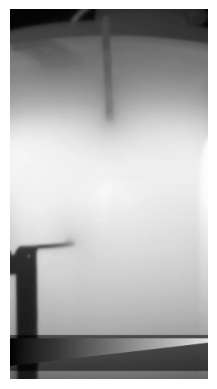

(480, 256)

In [8]:
_, x = img_gray.shape
# cutted_img = img_gray[:, int(x*0.60):int(x*(1-0.30))]

# apenas a região central será utilizada na análise
cutted_img = img_gray[:, int(x*0.30):int(x*(1 - 0.30))]

plt.imshow(cutted_img, cmap="gray")
plt.axis("off")
plt.show()

cutted_img.shape

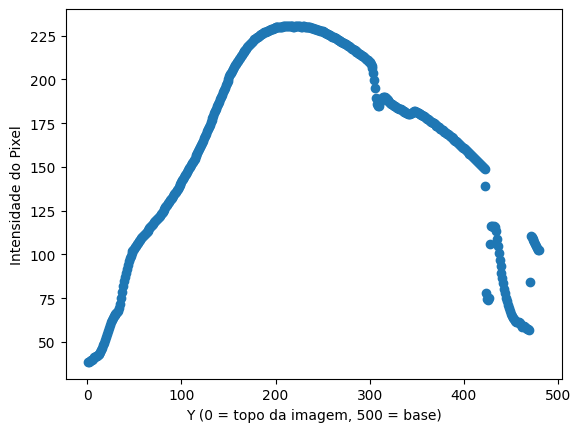

In [9]:
mean_pixel = cutted_img.mean(axis=1)
y_data = np.linspace(1, mean_pixel.shape[0], mean_pixel.shape[0]).astype(int)

plt.scatter(y_data, mean_pixel)
plt.ylabel("Intensidade do Pixel")
plt.xlabel("Y (0 = topo da imagem, 500 = base)")
plt.show()

Observe que o gráfico de distribuição apresentado acima contém algumas descontinuidades. Nesse caso, elas ocorrem devido ao gradiente de temperatura localizado na parte inferior da imagem. Para corrigi-las, será realizada a `remoção de 20% das bordas superior e inferior`. No caso da borda superior, essa remoção também contribui para excluir da imagem regiões em que a taxa de variação de temperatura é muito abrupta, ou seja, a transição entre o transformador e o ambiente.

In [10]:
rem = int(len(y_data)*0.2)
max_rem = len(y_data) - rem

y_new = y_data[rem:max_rem]
mean_pixel_new = mean_pixel[rem:max_rem]

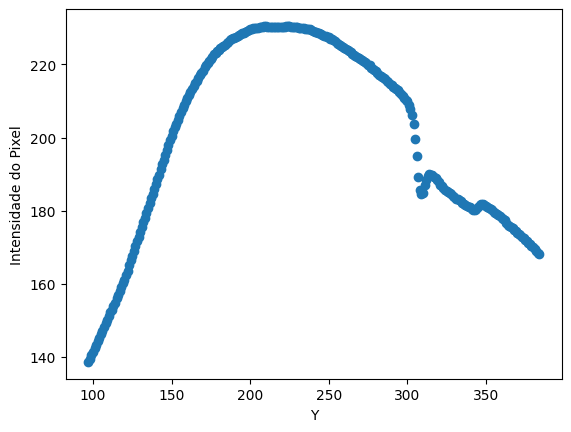

In [11]:
plt.scatter(y_new, mean_pixel_new)
plt.ylabel("Intensidade do Pixel")
plt.xlabel("Y")
plt.show()

In [12]:
len(y_new)

288

Para encontrar a função que melhor se ajusta a distribuição dos pontos acima, será utilizado o métodos os mínimos quadrados ajustado a um polinômio de grau definido por `int(len(y_new)/20)`. 

_**Nota**: A descontinuidade acima vista é devido a uma das hastes de fixação do transformador de potência_

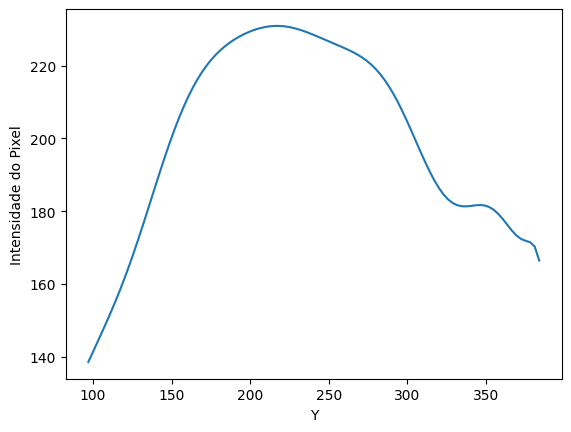

In [13]:
yp = np.linspace(min(y_new), max(y_new), 100)

coef = np.polyfit(y_new, mean_pixel_new, int(len(y_new)/20))
function = np.poly1d(coef)

plt.plot(yp, function(yp))
plt.ylabel("Intensidade do Pixel")
plt.xlabel("Y")
plt.show()

In [14]:
coef

array([-1.88170784e-27,  5.94125604e-24, -8.55219043e-21,  7.43244037e-18,
       -4.35290630e-15,  1.81574455e-12, -5.55819897e-10,  1.26731162e-07,
       -2.16110335e-05,  2.74098126e-03, -2.54406496e-01,  1.67524768e+01,
       -7.39876773e+02,  1.96251650e+04, -2.35932288e+05])

In [15]:
Y = symbols("Y")

# equação da intensidade dos pixels a partir dos coeficientes polinomiais
equation = sum(C*Y**exp for exp, C in enumerate(reversed(coef)))

# equação da taxa de variação desses pixels
dy_equation = equation.diff(Y)

range_ls = [(value, dy_equation.subs(Y, value)) for value in range(rem, max_rem)]

# remoção de 1% da borda
border = int(len(range_ls)*.01)
max_boder = len(range_ls) - border

# posição da máxima derivada
idy_max, _ = max(range_ls[border:max_boder], key=lambda i: i[1])
idy_max


137

In [16]:
equation

-1.88170783647561e-27*Y**14 + 5.94125604123873e-24*Y**13 - 8.55219042668062e-21*Y**12 + 7.43244036687701e-18*Y**11 - 4.35290630346962e-15*Y**10 + 1.81574454703663e-12*Y**9 - 5.55819897026682e-10*Y**8 + 1.26731161540712e-7*Y**7 - 2.16110334832237e-5*Y**6 + 0.00274098125827067*Y**5 - 0.25440649567809*Y**4 + 16.7524767939604*Y**3 - 739.8767733996*Y**2 + 19625.1650081676*Y - 235932.287800687

In [17]:
start_point = (0, int(idy_max))
end_point = (img.shape[1], int(idy_max))

Traçar uma linha horizontal para demarcar o nível do óleo, identificado pela maior taxa de variação, isto é, a região de máxima derivada, que corresponde à transição entre o óleo e o ar.

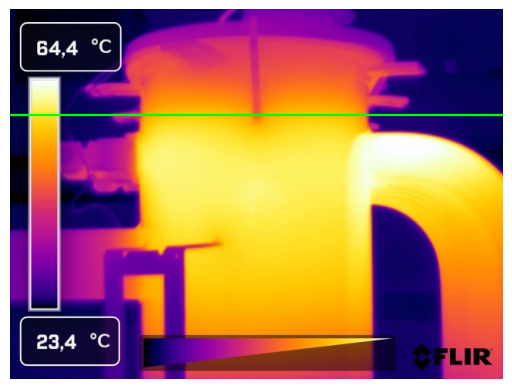

In [18]:
img_line = cv2.line(img.copy(), start_point , end_point, color=(0, 255, 0), thickness=2)

img_line = cv2.cvtColor(img_line, cv2.COLOR_BGR2RGB)
plt.imshow(img_line)
plt.axis("off")
plt.show()

## Validação do Identificador do Nível

In [19]:
def level_identification(img_path):
    """
    Função genérica para identificação do nível 
    """
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

    _, x = img_gray.shape
    # apenas a região central será utilizada na análise
    cutted_img = img_gray[:, int(x*0.30):int(x*(1 - 0.30))]

    mean_pixel = cutted_img.mean(axis=1)
    y_data = np.linspace(1, mean_pixel.shape[0], mean_pixel.shape[0]).astype(int)

    rem = int(len(y_data)*0.2)
    max_rem = len(y_data) - rem

    y_new = y_data[rem:max_rem]
    mean_pixel_new = mean_pixel[rem:max_rem]

    coef = np.polyfit(y_new, mean_pixel_new, int(len(y_new)/20))

    Y = symbols("Y")

    # equação da intensidade dos pixels a partir dos coeficientes polinomiais
    equation = sum(C*Y**exp for exp, C in enumerate(reversed(coef)))

    # equação da taxa de variação desses pixels
    dy_equation = equation.diff(Y)

    range_ls = [(value, dy_equation.subs(Y, value)) for value in range(rem, max_rem)]

    # remoção de 1% da borda
    border = int(len(range_ls)*.01)
    max_boder = len(range_ls) - border

    # posição da máxima derivada
    idy_max, _ = max(range_ls[border:max_boder], key=lambda i: i[1])

    start_point = (0, int(idy_max))
    end_point = (img.shape[1], int(idy_max))

    img_line = cv2.line(img.copy(), start_point , end_point, color=(0, 255, 0), thickness=2)

    img_line = cv2.cvtColor(img_line, cv2.COLOR_BGR2RGB)
    plt.imshow(img_line)
    plt.axis("off")
    plt.show()


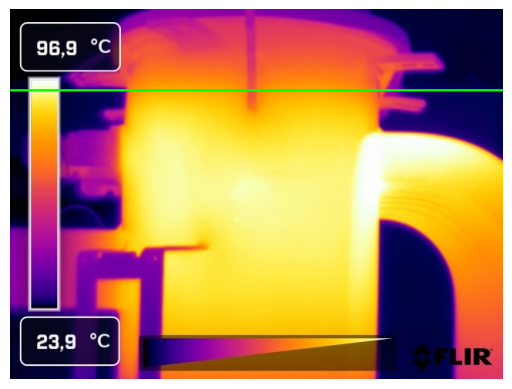

In [ ]:
df_new = df.copy()
df_new["level_idt"] = ""

for idx, row in df.iterrows():
    clear_output(wait=True)
    
    level_identification(row["img_path"])
    level = input("Qual nível foi identificado (1, 2, 3)? ")
    df_new.at[idx, "level_idt"] = level

df_new["level_idt"] = df_new["level_idt"].astype(int)

In [42]:
df_new

,nivel_do_oleo,temperatura_do_oleo_(co),face,codigo_da_foto,img_path,level_idt
0,1,60,Frontal,8653,images\raw_data_no_pointers\FLIR8653.jpg,3
1,1,70,Frontal,8659,images\raw_data_no_pointers\FLIR8659.jpg,1
2,1,80,Frontal,8665,images\raw_data_no_pointers\FLIR8665.jpg,1
3,1,90,Frontal,8673,images\raw_data_no_pointers\FLIR8673.jpg,1
4,2,50,Frontal,8679,images\raw_data_no_pointers\FLIR8679.jpg,2
5,2,60,Frontal,8685,images\raw_data_no_pointers\FLIR8685.jpg,2
6,2,70,Frontal,8705,images\raw_data_no_pointers\FLIR8705.jpg,2
7,2,80,Frontal,8691,images\raw_data_no_pointers\FLIR8691.jpg,2
8,2,90,Frontal,8697,images\raw_data_no_pointers\FLIR8697.jpg,2
9,3,50,Frontal,8713,images\raw_data_no_pointers\FLIR8713.jpg,3


mensurar a accuracia entre o nível dos resultados experimentais e o estimado

In [51]:
accuracy = (df_new["nivel_do_oleo"] == df_new["level_idt"]).mean()

accuracy.round(2)

np.float64(0.93)